# Get Fold Changes in control pools

## Content

1. Load modules
2. Import data
3. Functions to get FCs
4. Calculate ion intensity changes in control pools
5. Plot global baseline metabolism


## 1. Load modules

In [361]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set(color_codes=True)
from scipy import stats
from statsmodels.stats.multitest import multipletests
from datetime import date
import time
from collections import Counter

import random
import json

import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
# define date for saving figures
today = date.today().strftime("%Y-%m-%d") # for saving files
# set number of columns to show when display is called
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

## 2. Import data

In [3]:
# Set wd
os.chdir('/Users/clanc/OneDrive/Masterarbeit/analysis')

In [4]:
# Load info tables
screen_info = pd.read_csv('curated_input/screen_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_info = pd.read_csv('curated_input/strain_info.txt', \
                                   sep = ';', header = 0, index_col = 0)


In [5]:
# info on bad injections

bad_inject_info = pd.read_csv('intermed_results/01_noBadInjections/outliers.txt', \
                                   sep = ';', header = 0)

In [6]:
# Load ms data
targeted_ms_paths = glob.glob(\
    'intermed_results/04_normalization/data/targeted/*_tar_norm_*')
targeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                      for file in targeted_ms_paths]

norm_table_paths = glob.glob(\
    'intermed_results/04_normalization/data/untargeted/*_untar_norm_*')
untargeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in norm_table_paths]

del(targeted_ms_paths, norm_table_paths)


In [7]:
# strain index vector

strain_list = [table.columns[0].split('-')[3] for table in untargeted_perS_list]

# outliers by strain
bad_inject_perS = [list(bad_inject_info.loc[bad_inject_info['strain'] == strain, 'injection']) for strain in strain_list]

In [8]:
#Set bad injections to NA
for s_idx, s in enumerate(untargeted_perS_list):
    
    if len(bad_inject_perS[s_idx])>0:
        
        badInj = bad_inject_perS[s_idx]
        untargeted_perS_list[s_idx].loc[:,badInj] = np.nan
    

In [11]:
# Save strain list of untargeted data tables

with open("curated_input/strain_list_untar.json", "w") as write_file:
    json.dump(strain_list, write_file, indent=4)

## 3. Functions to get change stats

In [343]:
def draw_below_detect_ints(N, mean = 2000, std = 750, minimum = 100, maximum = 3900):
    drawn_vals = [-1]
    while (min(drawn_vals) < minimum or min(drawn_vals) > maximum):
        drawn_vals = np.random.normal(mean, std, N)
    return(drawn_vals)


In [344]:
def remove_outs(df):
    # Get quartiles and IQR
    Q1 = df.quantile(0.25, axis=1)
    Q3 = df.quantile(0.75, axis=1)
    IQR = Q3-Q1
    #detect outs
    df_bool = df.apply(lambda col: (col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)), axis=0)
    out_rm_vec = df_bool.sum(axis=1)
    df[df_bool] = np.nan
    return(df, out_rm_vec)

In [345]:
def calc_change_stats(df_red, cols_T00, cols_T12, true_miss_thresh = 2, \
                      imp_tol_num = 0, val_per_TP_thresh = 2, rm_outs = True, equal_var = False):
    
    # Exclude rows with insufficient number of values
    #--------------------
    # Get boolean vector of rows with insufficient number of signals:
    na_cases = ((df_red[cols_T00].notnull().sum(axis=1) <=1) & \
        (df_red[cols_T12].notnull().sum(axis=1) <=1))

    #set values to np.nan
    df_red.loc[na_cases,:] = np.nan
    
    
    # Draw values for truely missing intensities
    #--------------------
    # Get boolean vector of rows with insufficient number of signals:
    T00_imp_cases = ((df_red[cols_T00].notnull().sum(axis=1) <= imp_tol_num) & \
        (df_red[cols_T12].notnull().sum(axis=1) >= true_miss_thresh))

    T12_imp_cases = ((df_red[cols_T00].notnull().sum(axis=1) >= true_miss_thresh) & \
        (df_red[cols_T12].notnull().sum(axis=1) <= imp_tol_num))

    # get group sizes
    T00_size = len(cols_T00)
    T12_size = len(cols_T12)

    df_red.loc[T00_imp_cases,cols_T00] = [draw_below_detect_ints(T00_size) for\
                                          idx in range(sum(T00_imp_cases))]

    df_red.loc[T12_imp_cases,cols_T12] = [draw_below_detect_ints(T12_size) for\
                                          idx in range(sum(T12_imp_cases))]

    # impute 0 values
    #for row in df_red.index[T00_imp_cases]:
    #    vals = df_red.loc[row,cols_T00] 
    #    vals[np.isnan(vals)] = draw_below_detect_ints(sum(np.isnan(vals)))
    #    df_red.loc[row,cols_T00] = vals

    #for row in df_red.index[T12_imp_cases]:
    #    vals = df_red.loc[row,cols_T12] 
    #    vals[np.isnan(vals)] = draw_below_detect_ints(sum(np.isnan(vals)))
    #    df_red.loc[row,cols_T12] = vals
    
    
    # Remove outliers (if set to true)
    #--------------------
    # Check if outliers should be removed
    if rm_outs == True:
        # only consider group sizes >= 4
        if ((T00_size >=4) or (T12_size >= 4)) == True:
    
            T00_out_cands = (df_red[cols_T00].notnull().sum(axis=1) >= 4)
            T12_out_cands = (df_red[cols_T12].notnull().sum(axis=1) >= 4)

            df_T00 = df_red.loc[T00_out_cands, cols_T00].copy()
            df_T12 = df_red.loc[T12_out_cands, cols_T12].copy()

            df_T00_noOuts, df_T00_outs = remove_outs(df_T00)
            df_T12_noOuts, df_T12_outs = remove_outs(df_T12)

            df_red.loc[T00_out_cands, cols_T00] = df_T00_noOuts
            df_red.loc[T12_out_cands, cols_T12] = df_T12_noOuts

            T00_out_rm_info = pd.Series(0, index=df_red.index)
            T12_out_rm_info = pd.Series(0, index=df_red.index)

            T00_out_rm_info.loc[T00_out_cands] = df_T00_outs
            T12_out_rm_info.loc[T12_out_cands] = df_T12_outs
        
        else:
            T00_out_rm_info = pd.Series(np.nan, index=df_red.index)
            T12_out_rm_info = pd.Series(np.nan, index=df_red.index)
            print('Group size (',T00_size, 'and', T12_size,\
                  ') too small (<=3) to detect outliers.')
            
    else:
        T00_out_rm_info = pd.Series(np.nan, index=df_red.index)
        T12_out_rm_info = pd.Series(np.nan, index=df_red.index)
        print('No outliers were removed.')
        
    
    # Calculate change stats
    #--------------------
    
    T00_FC_cands = (df_red[cols_T00].notnull().sum(axis=1) >= val_per_TP_thresh)
    T12_FC_cands = (df_red[cols_T12].notnull().sum(axis=1) >= val_per_TP_thresh)
    FC_calc_cands = np.logical_and(T00_FC_cands, T12_FC_cands)
    
    val_cases = FC_calc_cands

    nan_templ = pd.Series(np.nan, index=df_red.index)

    T00_entries = df_red.loc[val_cases,cols_T00]
    T12_entries = df_red.loc[val_cases,cols_T12]

    T00_means = T00_entries.mean(axis = 1)
    nan_templ.loc[val_cases] = T00_means
    T00_means = nan_templ.copy()

    T12_means = T12_entries.mean(axis = 1)
    nan_templ.loc[val_cases] = T12_means
    T12_means = nan_templ.copy()

    FC_vals = T12_means.divide(T00_means)
    nan_templ.loc[val_cases] = FC_vals
    FC_vals = nan_templ.copy()

    PerC_vals = ((T12_means-T00_means).divide(T00_means))*100
    nan_templ.loc[val_cases] = PerC_vals
    PerC_vals = nan_templ.copy()

    _, P_vals = stats.ttest_ind(T00_entries, T12_entries, axis = 1 , equal_var = equal_var, nan_policy = 'omit')

    P_vals = np.ma.filled(P_vals,fill_value = np.nan)
    P_vals_noNA = ~ np.isnan(P_vals)
    noNA_vals = P_vals[P_vals_noNA]

    _,FDRvalues,_,_ = multipletests(noNA_vals, alpha=0.05, method='fdr_bh')

    # reset nan template
    nan_templ.loc[val_cases] = np.nan

    BH_val_templ = nan_templ.loc[val_cases].copy()
    BH_val_templ.loc[P_vals_noNA] = FDRvalues
    nan_templ.loc[val_cases] = BH_val_templ
    BH_vals = nan_templ.copy()

    nan_templ.loc[val_cases] = P_vals
    P_vals = nan_templ.copy()
    
    # change boolean vec to 
    return([T00_means, T12_means, FC_vals, PerC_vals, P_vals,\
            BH_vals, na_cases, T00_imp_cases, \
            T12_imp_cases, T00_out_rm_info, T12_out_rm_info]) #
    
 

## 4. Calculate ion intensity changes in control pools

In [346]:
def get_strain_res_tabs(table_idx):
    
    data_table = untargeted_perS_list[table_idx]
    
    strain = data_table.columns[0].split('-')[3]
    
    print('calculating', strain)

    col_names = [col for col in data_table.columns if 'Pool9' in col]
    cols_T00 = [col for col in col_names if 'T00' in col]
    cols_T12 = [col for col in col_names if 'T12' in col]

    df_red = data_table[cols_T00+cols_T12].copy()

    FC_control_res = calc_change_stats(df_red, cols_T00, cols_T12, true_miss_thresh = 2, \
                      imp_tol_num = 0, val_per_TP_thresh = 2, rm_outs = False, equal_var = False)
    
    # initialize result data frames
    T00_means = pd.DataFrame({'control': FC_control_res[0]},\
                                index = data_table.index)

    T12_means = pd.DataFrame({'control': FC_control_res[1]},\
                                index = data_table.index)

    FC_vals = pd.DataFrame({'control': FC_control_res[2]},\
                                index = data_table.index)

    PerC_vals = pd.DataFrame({'control': FC_control_res[3]},\
                                index = data_table.index)

    P_vals = pd.DataFrame({'control': FC_control_res[4]},\
                                index = data_table.index)

    BH_vals = pd.DataFrame({'control': FC_control_res[5]},\
                                index = data_table.index)

    na_cases = pd.DataFrame({'control': FC_control_res[6]},\
                                index = data_table.index)

    T00_imp_cases = pd.DataFrame({'control': FC_control_res[7]},\
                                index = data_table.index)

    T12_imp_cases = pd.DataFrame({'control': FC_control_res[8]},\
                                index = data_table.index)

    T00_out_rm_info = pd.DataFrame({'control': FC_control_res[9]},\
                                index = data_table.index)

    T12_out_rm_info = pd.DataFrame({'control': FC_control_res[10]},\
                                index = data_table.index)

    res_table_list = [T00_means, T12_means, FC_vals, PerC_vals, P_vals, BH_vals, na_cases,\
               T00_imp_cases, T12_imp_cases, T00_out_rm_info, T12_out_rm_info] # 

    
    return(res_table_list)


Run on all strains

In [347]:
control_res_all = [get_strain_res_tabs(i) for i in range(len(untargeted_perS_list))]

calculating S005
No outliers were removed.
calculating S006
No outliers were removed.
calculating S007
No outliers were removed.
calculating S008
No outliers were removed.
calculating S009
No outliers were removed.
calculating S010
No outliers were removed.
calculating S011
No outliers were removed.
calculating S012
No outliers were removed.
calculating S013
No outliers were removed.
calculating S014
No outliers were removed.
calculating S016
No outliers were removed.
calculating S017
No outliers were removed.
calculating S019
No outliers were removed.
calculating S020
No outliers were removed.
calculating S021
No outliers were removed.
calculating S022
No outliers were removed.
calculating S023
No outliers were removed.
calculating S024
No outliers were removed.
calculating S025
No outliers were removed.
calculating S026
No outliers were removed.
calculating S028
No outliers were removed.
calculating S029
No outliers were removed.
calculating S030
No outliers were removed.
calculating

## 5. Plot global baseline metabolism

Convert to data frame per strain

In [348]:
res_tab_labs = ['T00_means', 'T12_means', 'FC_vals', 'PerC_vals', \
                'P_vals', 'BH_vals', 'na_cases', 'T00_imp_cases', 'T12_imp_cases',\
                'T00_out_rm_info', 'T12_out_rm_info']

In [349]:
control_res_dfs = []

for res in control_res_all:
    df = pd.DataFrame(np.nan, columns = [], index = res[0].index)
    for idx,col_df in enumerate(res):
        col_df.columns = [res_tab_labs[idx]]
        df = pd.concat([df, col_df], axis = 1)
    
    control_res_dfs.append(df)

Plot volcano of all baselines

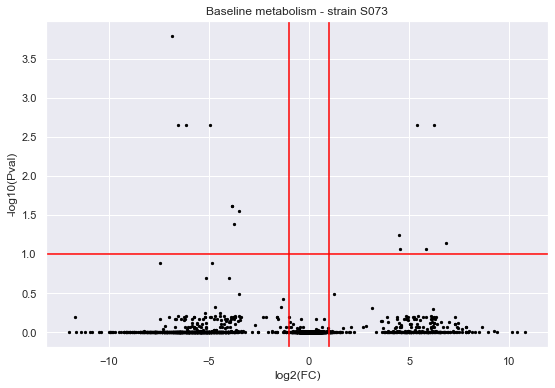

In [351]:
strain_idx = 64

test_res = control_res_dfs[strain_idx]
    
bool_vec = np.logical_and(abs(np.log2(test_res['FC_vals']))>1,\
                      test_res['P_vals']<0.1)

#peak_count.append(sum(bool_vec))

plt.figure(figsize=(9,6))

plt.scatter(np.log2(test_res['FC_vals']), 
            -np.log10(test_res['BH_vals']),
            s = 5, c = 'black')

plt.axvline(x = -1, c = 'red')
plt.axvline(x = 1, c = 'red')

plt.axhline(y = -np.log10(0.1), c = 'red')

plt.xlabel('log2(FC)')
plt.ylabel('-log10(Pval)')


plt.title('Baseline metabolism - strain '+strain_list[strain_idx])

#plt.savefig('intermed_results/15_base_overview/volcanos/'+\
#           str(strain_idx).zfill(2)+'_volcano_contr_'+strain_list[strain_idx]+'.pdf',
#           bbox_inches='tight')

plt.show()


In [1]:
#peak_count = []
#
#for strain_idx,_ in enumerate(strain_list):
#    
#    test_res = control_res_dfs[strain_idx]
#    
#    bool_vec = np.logical_and(abs(np.log2(test_res['FC_vals']))>1,\
#                          test_res['BH_vals']<0.1)
#   
#    peak_count.append(sum(bool_vec))
#    
#    plt.figure(figsize=(9,6))
#
#    plt.scatter(np.log2(test_res['FC_vals']), 
#                -np.log10(test_res['BH_vals']),
#                s = 5, c = 'black')
#
#    plt.axvline(x = -1, c = 'red')
#    plt.axvline(x = 1, c = 'red')
#
#    plt.axhline(y = -np.log10(0.1), c = 'red')
#
#    plt.xlabel('log2(FC)')
#    plt.ylabel('-log10(Pval)')
#
#
#    plt.title('Baseline metabolism - strain '+strain_list[strain_idx])
#    
#    plt.savefig('intermed_results/15_base_overview/volcanos/'+\
#               str(strain_idx).zfill(2)+'_volcano_contr_'+strain_list[strain_idx]+'.pdf',
#               bbox_inches='tight')
#
#    plt.show()
#    
#    plt.close('all')

In [353]:
phyla = list(strain_info.loc[:,"phylum"].unique())
lut_phyl = dict(zip(phyla, sns.hls_palette(len(phyla))))

phyl_list = [strain_info.loc[s, "phylum"] for s in strain_list]

phyl_col_list = pd.Series(phyl_list).map(lut_phyl)

In [364]:
cols = list(lut_phyl.values())

In [365]:
labels = list(lut_phyl.keys())

In [366]:
patches = [mpatches.Patch(color=c, label=l) for c,l in zip(cols, labels)]

In [354]:
base_metabo_df = pd.DataFrame({'strain':strain_list,\
                               'number_of_metabolites':peak_count,\
                               'phylum':phyl_list,\
                               'phyl_col':phyl_col_list})

In [357]:
base_metabo_df = base_metabo_df.sort_values(by ='number_of_metabolites',\
                                            ascending = False)

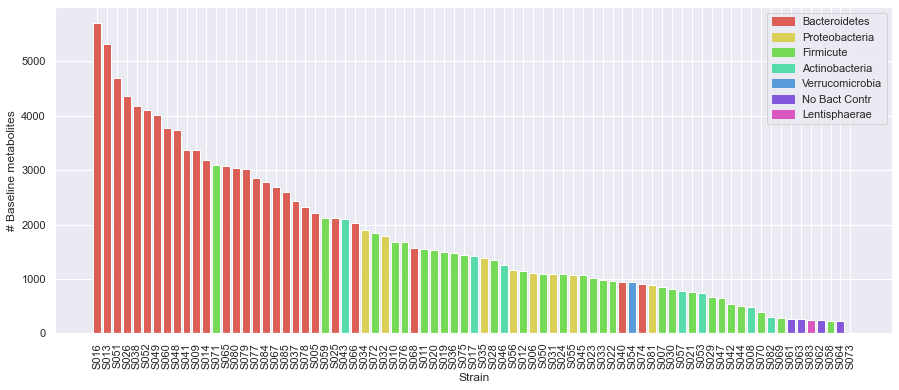

In [369]:
plt.figure(figsize=(15,6))

plt.bar(base_metabo_df['strain'], base_metabo_df['number_of_metabolites'],\
        color = base_metabo_df['phyl_col'])

plt.ylabel('# Baseline metabolites')
plt.xlabel('Strain')
plt.xticks(rotation=90)

plt.legend(handles=patches)

plt.savefig('intermed_results/15_base_overview/base_metabolite_overview.pdf',
               bbox_inches='tight')

plt.show()

In [382]:
base_metabo_df.index = base_metabo_df['strain']
base_metabo_df[65:]

strain  number_of_metabolites          phylum  \
strain                                                 
S044     S044                    504       Firmicute   
S008     S008                    487  Actinobacteria   
S070     S070                    395       Firmicute   
S082     S082                    295  Actinobacteria   
S069     S069                    288       Firmicute   
S061     S061                    268   No Bact Contr   
S063     S063                    264   No Bact Contr   
S083     S083                    252   Lentisphaerae   
S062     S062                    244   No Bact Contr   
S058     S058                    228       Firmicute   
S064     S064                    225   No Bact Contr   
S073     S073                     14       Firmicute   

                                               phyl_col  
strain                                                   
S044    (0.4573714285714283, 0.86, 0.33999999999999997)  
S008    (0.33999999999999997, 0.86, 0.6683428571428571)  
S070    (0.4573714285714283, 0.86, 0.33999999999999997)  
S082    (0.33999999999999997, 0.86, 0.6683428571428571)  
S069    (0.4573714285714283, 0.86, 0.33999999999999997)  
S061    (0.5197714285714281, 0.33999999999999997, 0.86)  
S063    (0.5197714285714281, 0.33999999999999997, 0.86)  
S083    (0.86, 0.33999999999999997, 0.7545142857142858)  
S062    (0.5197714285714281, 0.33999999999999997, 0.86)  
S058    (0.4573714285714283, 0.86, 0.33999999999999997)  
S064    (0.5197714285714281, 0.33999999999999997, 0.86)  
S073    (0.4573714285714283, 0.86, 0.33999999999999997)

In [383]:
base_metabo_df_red = base_metabo_df.loc[base_metabo_df['number_of_metabolites']>300,:]

In [390]:
base_metabo_df_red.shape

(68, 4)